In [1]:
import pandas as pd
import numpy as np
import os
import math
from sklearn.cluster import KMeans
%config IPCompleter.greedy=True

In [2]:
# Data Files
OUTPUT_DIR = 'outputs/'
INPUT_DIR = 'data/'

HOD_same = 'HumanObserved-Dataset/same_pairs.csv'
HOD_diff = 'HumanObserved-Dataset/diffn_pairs.csv'
HOD_features = 'HumanObserved-Dataset/HumanObserved-Features-Data.csv'

GSC_same = 'GSC-Dataset/same_pairs.csv'
GSC_diff = 'GSC-Dataset/same_pairs.csv'
GSC_features = 'GSC-Dataset/GSC-Features.csv'

In [3]:
# Linear Regression Variables
TrainingPercent = 80 # Data Split for Training Data
ValidationPercent = 10 # Data Split for Validation Data
TestPercent = 10 # Data Split for Testing Data


M = 10
C_Lambda = 0.03
learningRate = 0.01


In [4]:
def _remove_zero_cols(data):
    """Returns ndarray with no zero columns
    """
    data = data.transpose()
    data = data[~np.all(data == 0, axis=1)]
    data = data.transpose()
    return data


def _append_dataframes(same_data, diff_data):
    """Appends the dataframes one after another.
    """
    appended_data = pd.concat([same_data, diff_data])
    appended_data = appended_data.sample(frac=1)
    return(appended_data)


In [5]:
def _concat_dataframes(same_data, diff_data, features_data):
    """
    """
    # Combine the diff and concat data
    appended_data = _append_dataframes(same_data, diff_data)
    # Remove columns if exist
    if 'Unnamed: 0' in features_data.columns.values:
        features_data = features_data.drop(columns=['Unnamed: 0'])

    # Merge the datatables, same and diff
    merged_data = pd.merge(appended_data, features_data,
                           left_on='img_id_A', right_on='img_id', how='left')
    merged_data = pd.merge(merged_data, features_data, left_on='img_id_B',
                           right_on='img_id', how='left', suffixes=('_a', '_b'))
    merged_data = merged_data.drop(columns=['img_id_a', 'img_id_b'])
    raw_data = merged_data.loc[:, 'f1_a':].values
    raw_data = _remove_zero_cols(raw_data)
    raw_target = merged_data['target'].values
    return(raw_data, raw_target)


def _subtract_dataframes(same_data, diff_data, features_data):
    """Subtract img_id_a columns with img_id_b_columns
    """
    appended_data = _append_dataframes(same_data, diff_data)
    temp1 = pd.merge(appended_data, features_data,
                     left_on='img_id_A', right_on='img_id', how='left')
    temp2 = pd.merge(appended_data, features_data,
                     left_on='img_id_B', right_on='img_id', how='left')
    raw_data = abs(temp1.loc[:, 'f1':] - temp2.loc[:, 'f1':]).values

    raw_data = _remove_zero_cols(raw_data)
    raw_target = appended_data['target'].values

    return(raw_data, raw_target)


In [6]:
def get_data_features(category='hod', operation='concat'):
    """Returns concat/subtracted feature values
    Merge the same and diff datasets, and process the data columns
    """
    category_dict = {
        'hod': [HOD_same, HOD_diff, HOD_features],
        'gsc': [GSC_same, GSC_diff, GSC_features],
    }
    same, diff, features = category_dict[category]
    same_data = pd.read_csv(os.path.join(INPUT_DIR, same), sep=',', nrows=1000)
    diff_data = pd.read_csv(os.path.join(
        INPUT_DIR, diff),  sep=',', nrows=1000)
    features_data = pd.read_csv(os.path.join(INPUT_DIR, features), sep=',')

    if operation == 'concat':
        raw_data, raw_target = _concat_dataframes(
            same_data, diff_data, features_data)

    if operation == 'subtract':
        raw_data, raw_target = _subtract_dataframes(
            same_data, diff_data, features_data)

    return(raw_data, raw_target)


In [13]:
data1_d, data1_t = get_data_features('hod', operation='concat')
# print(data1_d.shape, data1_t.shape)
# data1_d, data1_t = get_data_features('hod', operation='subtract')
# print(data1_d.shape, data1_t.shape)
# data1_d, data1_t = get_data_features('gsc', operation='concat')
print(data1_d.shape, data1_t.shape)
# data4_d, data4_t = get_data_features('gsc', operation='subtract')
# print(data4_d.shape, data4_t.shape)

(1791, 18) (1791,)


In [14]:
training_ratio = math.floor(data1_d.shape[0]*.8)
val_test_ratio = math.floor(data1_d.shape[0]*.9)

training_data, training_target = data1_d[:training_ratio], data1_t[:training_ratio]
validation_data, validation_target  = data1_d[training_ratio:val_test_ratio], data1_t[training_ratio:val_test_ratio]
testing_data, testing_target = data1_d[val_test_ratio:], data1_t[val_test_ratio:]
data1_d, training_data, testing_data, validation_data = data1_d.transpose(), training_data.transpose(), testing_data.transpose(), validation_data.transpose()
print(training_data.shape, testing_data.shape, validation_data.shape)
print(training_target.shape, testing_target.shape, validation_target.shape)
# 

(18, 1432) (18, 180) (18, 179)
(1432,) (180,) (179,)


In [59]:
# from math import e
# from array import array
# def h(x,theta):
#     """
#     logistic regression hypothesis function
#     """
#     print('2')
#     return e**(np.dot(x,theta))/(1.+e**(np.dot(x,theta)))

# def log_reg_regularized_sgd(x,y,a,l=0.1,max_iter=100,debug=True):
#     """
#     Stochastic gradient descent for logistic regression with regularization
#     and static learning rate
#     x = training data
#     y training label
#     a = learning rae
#     l = regularized constance
#     """
#     if debug: 
#         print('1')
#         err = array('f',[])
#     #initialize algorithm state
#     m,n = x.shape
#     theta = np.random.random(n)
#     z = np.arange(m)
#     for t in range(max_iter):
#         print(t)
#         #shuffle indices prior to searching
#         z = np.random.permutation(z)
#         #for each training example
#         for i in z:
#             #update weights
#             theta = theta + a*(y[i]-h(x[i],theta))*x[i] - l*2.*a*theta
#             #compute the error, current incorrect
#             if debug:err.append(sum([(y[i]-h(x[i],theta))**2 for i in range(m)]))
#     if debug: return theta,err
#     return theta

In [63]:
# a = 0.001
# x = training_data
# y = training_target
# theta, err = log_reg_regularized_sgd(x,y,a, max_iter=100)

1
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


/Users/ameenkhan/dev/projects/Machine-Learning/Project2/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/ameenkhan/dev/projects/Machine-Learning/Project2/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
17
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
18
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
31
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
44
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
45
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
59
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
72
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
73
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
86
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
87
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [64]:
def Declare_Winner(theta):
    score = 0
    #first scikit LR is tested for each independent var in the dataset and its prediction is compared against the dependent var
    #if the prediction is the same as the dataset measured value it counts as a point for thie scikit version of LR
#     scikit_score = clf.score(X_test,Y_test)
    X_test = testing_data.transpose()
    Y_test = testing_target.transpose()
    length = len(X_test)
    # Iterate over all rows
    for i in range(length):
        prediction = round(Hypothesis(X_test[i],theta))
        answer = Y_test[i]
        if prediction == answer:
            score += 1
    #the same process is repeated for the implementation from this module and the scores compared to find the higher match-rate
    accuracy = float(score) / float(length)
    print('Your score: ', accuracy)

In [54]:
# X = training_data.transpose()
# Y = training_target.transpose()
# training_data.shape[0]
# initial_weights = [0]*training_data.shape[0]
# alpha = 0.1
# iterations = 1
# Logistic_Regression(X,Y,alpha,initial_weights,iterations)

In [65]:
from sklearn.linear_model import LogisticRegression
X, y = training_data, training_target

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

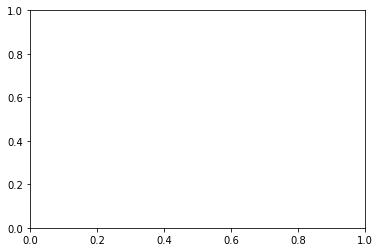

In [81]:
# Learning Rate = 0.1
plt.plot([0.01,0.03,0.05,0.08, 0.1, 0.5],[0,0,0,0,0,0], label = 'HOD CONCAT')
# plt.plot([256,512,1024,2048],[0,0,0,0], label = 'HOD SUBTRACT')
# plt.plot([256,512,1024,2048],[0,0,0,0], label = 'GSC CONCAT')
# plt.plot([256,512,1024,2048],[0,0,0,0], label = 'GSC SUBTRACT')
plt.ylabel('Testing Accuracy')
plt.xlabel('Hidden Nodes (First Layer)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.show()

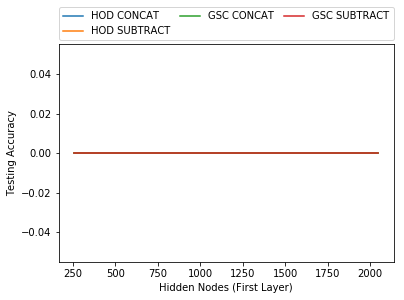

In [80]:
# Learning Rate = 0.1
plt.plot([256,512,1024,2048],[0,0,0,0], label = 'HOD CONCAT')
plt.plot([256,512,1024,2048],[0,0,0,0], label = 'HOD SUBTRACT')
plt.plot([256,512,1024,2048],[0,0,0,0], label = 'GSC CONCAT')
plt.plot([256,512,1024,2048],[0,0,0,0], label = 'GSC SUBTRACT')
plt.ylabel('Testing Accuracy')
plt.xlabel('Hidden Nodes (First Layer)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.show()

In [66]:
import matplotlib.pyplot as plt

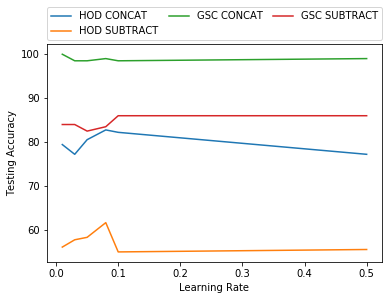

In [95]:
# M = 10
plt.plot([0.01,0.03,0.05,0.08,0.1,0.5],[79.44,77.22,80.55,82.77,82.22,77.22], label = 'HOD CONCAT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.5],[56.11, 57.77, 58.33, 61.67, 55.01, 55.56 ], label = 'HOD SUBTRACT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.5],[99.99, 98.5, 98.5, 99, 98.5, 99], label = 'GSC CONCAT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.5],[84, 84, 82.5, 83.5, 86, 86], label = 'GSC SUBTRACT')
plt.ylabel('Testing Accuracy')
plt.xlabel('Learning Rate')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.show()